In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import random

from pretrained_models.bisonai.model import OmniglotModelBisonai

In [2]:
### Parameters

num_classes = 3
learning_rate = 0.001
epochs = 5
checkpoint_path = "pretrained_models/bisonai/1shot_3way_bisonai_ckpt_o15t/model.ckpt-99999"

def softmax(x):
    e = np.exp(x)
    return (e / np.sum(e, axis=1, keepdims=True))

## Data for fine-tuning & prediction

In [3]:
sess = tf.Session()

omniglot_train = tfds.load(name="omniglot", split=tfds.Split.TRAIN).batch(2000)
omniglot_example = omniglot_train.take(1)
omniglot_example_iter = omniglot_example.make_initializable_iterator()
sess.run(omniglot_example_iter.initializer)

data = omniglot_example_iter.get_next()
image = data['image']
label = data['label']
x, y = sess.run([image,label])

X_train = resize(np.array(x[:num_classes,:,:,:])/255.0, (3, 28, 28, 1))
y_train = np.array(y[:num_classes])

In [4]:
print(X_train.shape)
y_train

(3, 28, 28, 1)


array([512, 854, 887])

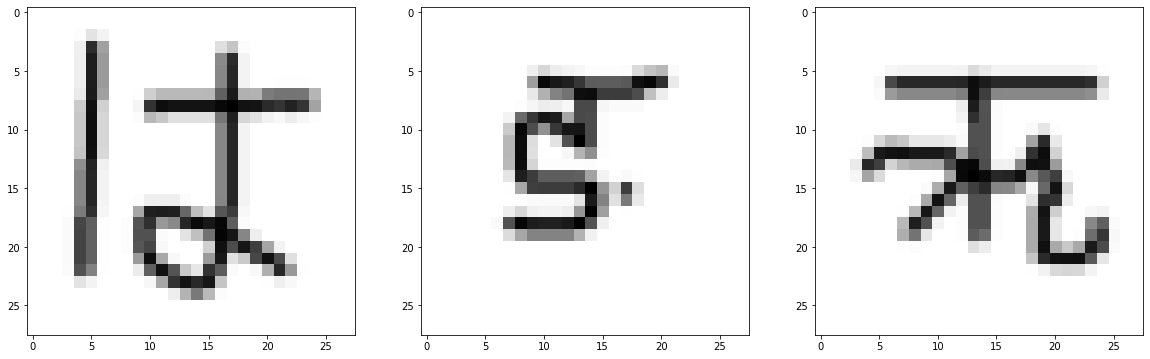

In [5]:
### Showing Images of the 3 classes after reshape 28x28x1

plt.figure(figsize=(20,20))
plt.subplot(131)
imgplot = plt.imshow(X_train[0,:,:,0], cmap="gist_gray")
plt.subplot(132)
imgplot = plt.imshow(X_train[1,:,:,0], cmap="gist_gray")
plt.subplot(133)
imgplot = plt.imshow(X_train[2,:,:,0], cmap="gist_gray")

In [6]:
res = sum([np.where(y == c)[0].tolist() for c in y_train], [])
[res.remove(i) for i in range(num_classes)]

ind = random.choice(res)
X_predict = resize(x[ind,:,:,0]/255.0, (28,28)).reshape((1, 28, 28,1))
y_predict = y[ind]

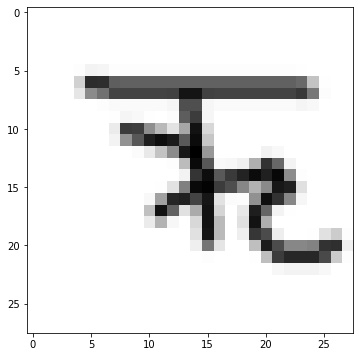

In [7]:
###### Showing the image with class to predict

plt.figure(figsize=(6,6))
imgplot = plt.imshow(X_predict[0,:,:,0], cmap="gist_gray")

## Preparing the model & prediction

In [8]:
model = OmniglotModelBisonai(num_classes=3, **{'learning_rate':learning_rate})
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

In [9]:
y_train_label = np.array([0, 1, 2])

adam_var = [i for i in tf.all_variables() if "Adam_1" in i.name]

for e in range(epochs):

    #loss = sess.run(model.loss, feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph: y_train_label})
    #print("loss", loss)

    #logits = sess.run(model.logits, feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})
    #print("test softmax", softmax(logits))
    sess.run(model.minimize_op, feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph:y_train_label})
result, logits = sess.run([model.predictions, model.logits], feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})

print("The predicted class number is {} and the real class number is {}.".format(y_train[result[0]],y_predict))
print("The probability distribution is {}.".format(softmax(logits)))

The predicted class number is 887 and the real class number is 887.
The probability distribution is [[0.27328706 0.20178133 0.5249316 ]].
